<a href="https://colab.research.google.com/github/naomifridman/DeepLearning_timeseries_introduction/blob/main/Example_Sensor_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# From  [LSTM Autoencoder for Anomaly Detection](https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf)
# [ Brent Larzalere's gitub ](https://github.com/BLarzalere/LSTM-Autoencoder-for-Anomaly-Detection)
## Bearing Failure Anomaly Detection
In this workbook, we use an autoencoder neural network to identify vibrational anomalies from sensor readings in a set of bearings. The goal is to be able to predict future bearing failures before they happen. The vibrational sensor readings are from the NASA Acoustics and Vibration Database. Each data set consists of individual files that are 1-second vibration signal snapshots recorded at 10 minute intervals. Each file contains 20,480 sensor data points that were obtained by reading the bearing sensors at a sampling rate of 20 kHz.

This autoencoder neural network model is created using Long Short-Term Memory (LSTM) recurrent neural network (RNN) cells within the Keras / TensorFlow framework.

In [13]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

In [14]:
plt.rcParams['figure.figsize'] = [18, 5]
pd.options.display.max_columns = 100

In [15]:
# set random seed
import random
random.seed(10)


# Data loading and pre-processing
An assumption is that mechanical degradation in the bearings occurs gradually over time; therefore, we use one datapoint every 10 minutes in the analysis. Each 10 minute datapoint is aggregated by using the mean absolute value of the vibration recordings over the 20,480 datapoints in each file. We then merge together everything in a single dataframe.

In [16]:
!git clone https://github.com/naomifridman/DeepLearning_timeseries_introduction


fatal: destination path 'DeepLearning_timeseries_introduction' already exists and is not an empty directory.


In [17]:
merged_data = pd.read_csv('DeepLearning_timeseries_introduction/data/bearing_sensors.csv')
merged_data = merged_data.set_index('date', drop=True)
merged_data.index = pd.to_datetime(merged_data.index)#, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
date,,,,
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


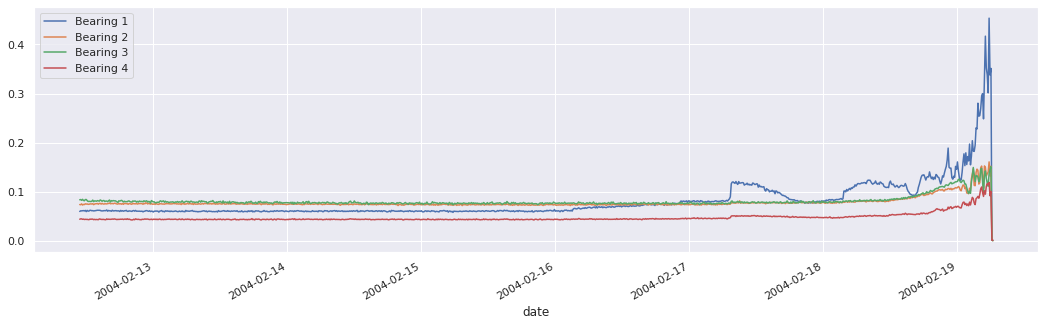

In [18]:
merged_data.plot()

# Define train/test data
Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions) and test on the remaining parts of the dataset leading up to the bearing failure.

In [19]:
train = merged_data['2004-02-12 10:52:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (445, 4)
Test dataset shape: (538, 4)


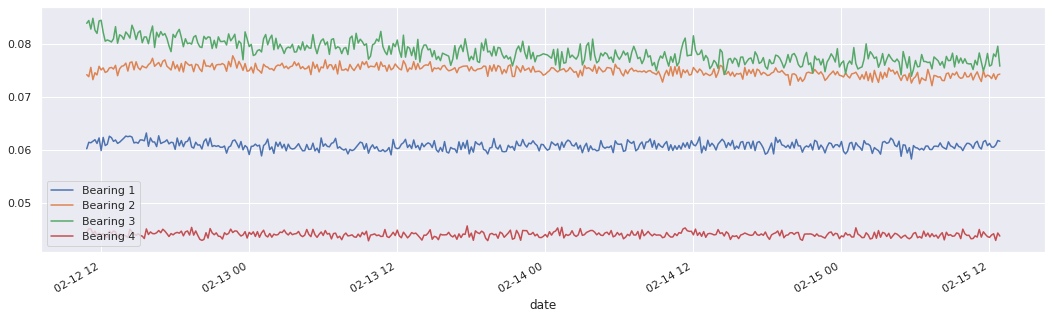

In [20]:
train.plot()

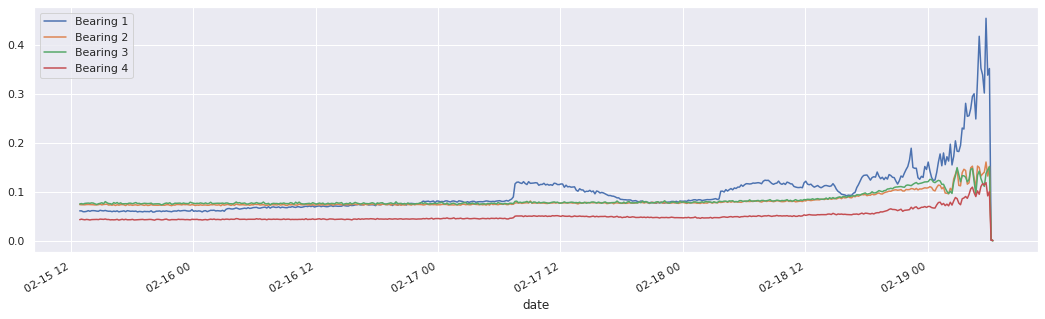

In [21]:
test.plot()

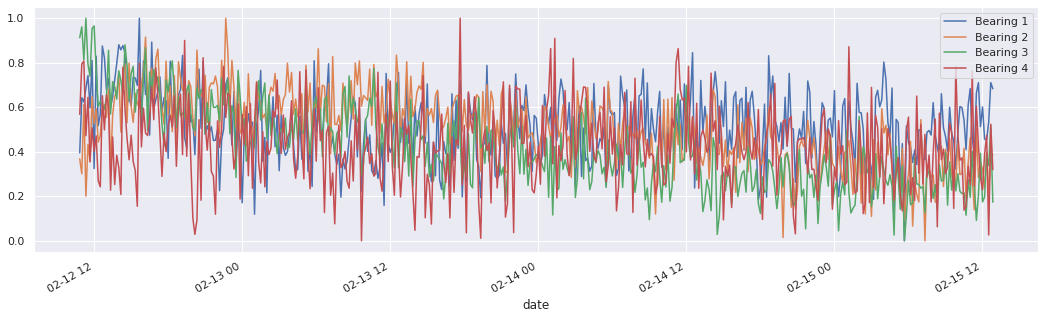

In [22]:
x = train.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
train_mm = pd.DataFrame(x_scaled, columns=train.columns)
train_mm = train_mm.set_index(train.index)
train_mm.plot()

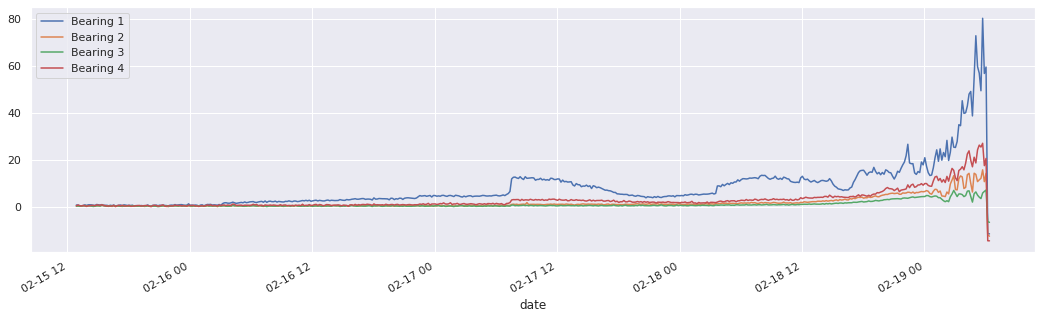

In [23]:
x = test.values #returns a numpy array
x_scaled = min_max_scaler.transform(x)
test_mm = pd.DataFrame(x_scaled, columns=train.columns)
test_mm = test_mm.set_index(test.index)
test_mm.plot()

In [24]:
X_train = train_mm.values
X_test = test_mm.values
X_train.shape, X_test.shape

((445, 4), (538, 4))

In [25]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (445, 1, 4)
Test data shape: (538, 1, 4)


In [26]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [27]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 16)             1344      
                                                                 
 lstm_5 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1, 4)             0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_7 (LSTM)               (None, 1, 16)             1344      
                                                           

In [28]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
43/43 [==============================] - 13s 55ms/step - loss: 0.4440 - val_loss: 0.3159
Epoch 2/100
43/43 [==============================] - 1s 15ms/step - loss: 0.3739 - val_loss: 0.2315
Epoch 3/100
43/43 [==============================] - 1s 13ms/step - loss: 0.2497 - val_loss: 0.1115
Epoch 4/100
43/43 [==============================] - 0s 11ms/step - loss: 0.1118 - val_loss: 0.1258
Epoch 5/100
43/43 [==============================] - 1s 13ms/step - loss: 0.1049 - val_loss: 0.1214
Epoch 6/100
43/43 [==============================] - 0s 11ms/step - loss: 0.1031 - val_loss: 0.1157
Epoch 7/100
43/43 [==============================] - 1s 12ms/step - loss: 0.1027 - val_loss: 0.1169
Epoch 8/100
43/43 [==============================] - 0s 6ms/step - loss: 0.1019 - val_loss: 0.1151
Epoch 9/100
43/43 [==============================] - 0s 6ms/step - loss: 0.1017 - val_loss: 0.1159
Epoch 10/100
43/43 [==============================] - 0s 6ms/step - loss: 0.1014 - val_loss: 0.1144
E

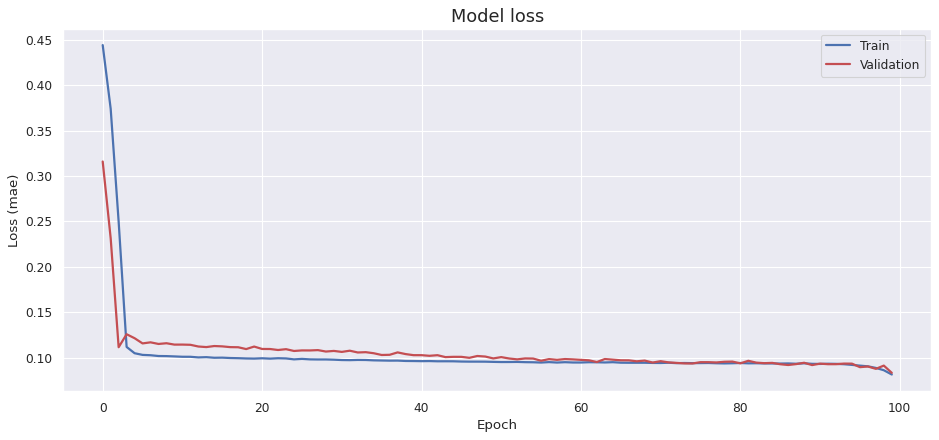

In [29]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level” and that any flagged anomalies should be statistically significant above the background noise.

In [30]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=[c+' pred' for c in train.columns])
X_pred.index = train.index
df_train = pd.concat([train_mm, X_pred], axis=1)
df_train.head()

14/14 [==============================] - 1s 2ms/step


,Bearing 1,Bearing 2,Bearing 3,Bearing 4,Bearing 1 pred,Bearing 2 pred,Bearing 3 pred,Bearing 4 pred
date,,,,,,,,
2004-02-12 10:52:39,0.395181,0.368517,0.912959,0.568334,0.599881,0.686762,0.608940,0.513969
2004-02-12 11:02:39,0.643046,0.300944,0.961482,0.794650,0.804542,0.711676,0.615271,0.740291
2004-02-12 11:12:39,0.623794,0.612662,0.813490,0.807756,0.819982,0.758320,0.678864,0.757960
2004-02-12 11:22:39,0.685621,0.201061,1.000000,0.472299,0.640842,0.675532,0.586805,0.558701
2004-02-12 11:32:39,0.742365,0.433217,0.794267,0.644737,0.742575,0.689803,0.592217,0.670536


In [31]:
df_train['Loss_mae'] = np.mean(np.abs(df_train[df_train.columns[0:4]].values-df_train[df_train.columns[4:]].values), axis = 1)

In [32]:
df_train.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,Bearing 1 pred,Bearing 2 pred,Bearing 3 pred,Bearing 4 pred,Loss_mae
date,,,,,,,,,
2004-02-12 10:52:39,0.395181,0.368517,0.912959,0.568334,0.599881,0.686762,0.608940,0.513969,0.220333
2004-02-12 11:02:39,0.643046,0.300944,0.961482,0.794650,0.804542,0.711676,0.615271,0.740291,0.243200
2004-02-12 11:12:39,0.623794,0.612662,0.813490,0.807756,0.819982,0.758320,0.678864,0.757960,0.131567
2004-02-12 11:22:39,0.685621,0.201061,1.000000,0.472299,0.640842,0.675532,0.586805,0.558701,0.254712
2004-02-12 11:32:39,0.742365,0.433217,0.794267,0.644737,0.742575,0.689803,0.592217,0.670536,0.121161


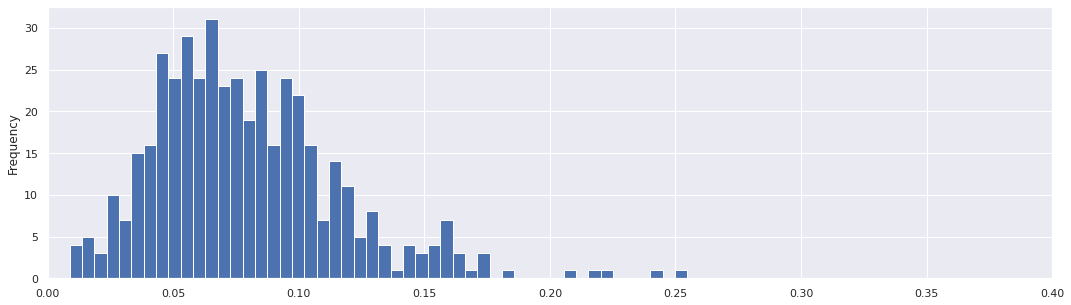

In [33]:
df_train['Loss_mae'].plot(kind='hist', bins=50, xlim=(0,0.4))


From the above loss distribution, let's try a threshold value of 0.275 for flagging an anomaly. We can then calculate the loss in the test set to check when the output crosses the anomaly threshold.

Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

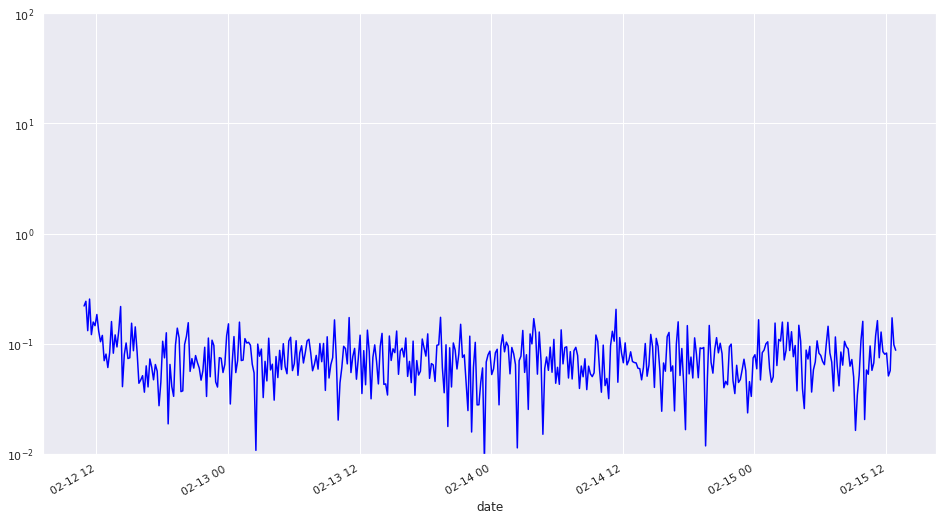

In [34]:
df_train['Loss_mae'].plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

In [35]:
# plot the loss distribution of the training set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=[c+' pred' for c in test.columns])
X_pred.index = test.index
df_test = pd.concat([test_mm, X_pred], axis=1)
df_test['Loss_mae'] = np.mean(np.abs(df_test[df_test.columns[0:4]].values-df_test[df_test.columns[4:]].values), axis = 1)

17/17 [==============================] - 0s 2ms/step


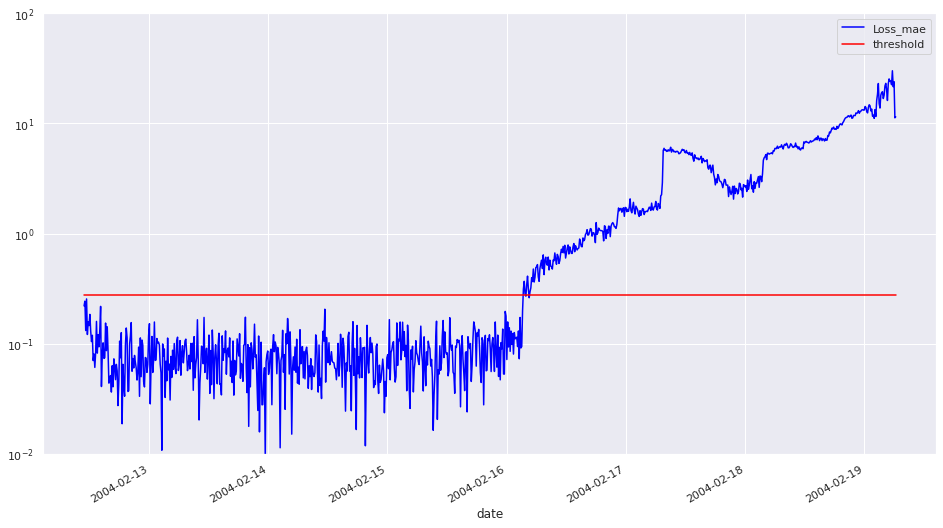

In [36]:
df = pd.concat([df_train, df_test])
df['threshold'] = 0.275
df[['Loss_mae', 'threshold']].plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

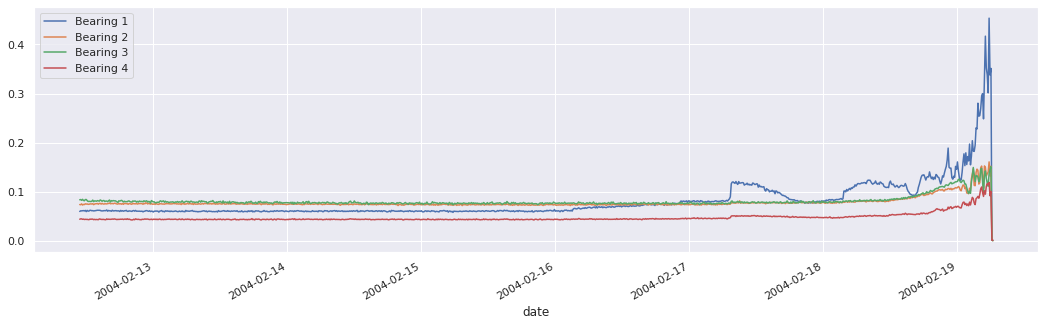

In [37]:
merged_data.plot()

This analysis approach is able to flag the upcoming bearing malfunction well in advance of the actual physical failure. It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal operating conditions.